## Import Modules

In [1]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

## Settingup Base and working Directory

In [2]:
BASE_DIR = '/kaggle/input/flickr8k'
WORKING_DIR = '/kaggle/working'

## Exract Image Features

In [3]:
# load vgg16 model
model = VGG16()

# restructure the model, leaving the predictions layer
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

# summerize the model
print(model.summary())

2022-12-27 13:55:54.911112: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-27 13:55:54.912101: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-27 13:55:55.069696: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-27 13:55:55.070661: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-27 13:55:55.071587: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

553476096/553467096 [==============================] - 3s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [4]:
# extract features from the image
features = {}
directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    
    # convert image pixels to numpy array
    image = img_to_array(image)
    
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    
    # preprocess image for vgg
    image = preprocess_input(image)
    
    # extract features
    feature = model.predict(image, verbose=0)
    
    # get image ID
    image_id = img_name.split('.')[0]
    
    # store feature
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

2022-12-27 13:56:03.225358: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-12-27 13:56:04.711723: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


In [6]:
# store features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [6]:
# load features from pickle
with open(os.path.join(WORKING_DIR, 'features.pkl')) as f:
    features = pickle.load(f)

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x80 in position 0: invalid start byte

## Load the Captions Data

In [5]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [6]:
# create mapping of image to captions
mapping = {}

# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    
    # convert caption list to string
    caption = " ".join(caption)
    
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [7]:
len(mapping)

8091

## Preprocess the Captions Data

In [8]:
# function for preprocessing the captions

def cleanCaption(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            
            # preprocesssing steps 
            
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special, charts, etc
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to captions
            caption = 'startseq ' + ' '.join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [9]:
# before preprocessing the text
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [13]:
# preprocess the text
# cleanCaption(mapping)

In [10]:
# preprocess the text
cleanCaption(mapping)

# after preprocessing the text
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [11]:
all_captions = []

for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [12]:
len(all_captions)

40455

In [13]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [14]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [15]:
vocab_size

8485

In [16]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

## Train Test Split

In [17]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [18]:
# create data generator to get data in batch (avoids session crash due to consumption of memory)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
   # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split The sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # padding input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
                
                if n==batch_size:

                    
                    X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                    yield [X1, X2], y
                    X1, X2, y = list(), list(), list()
                    n = 0

## Model Creation

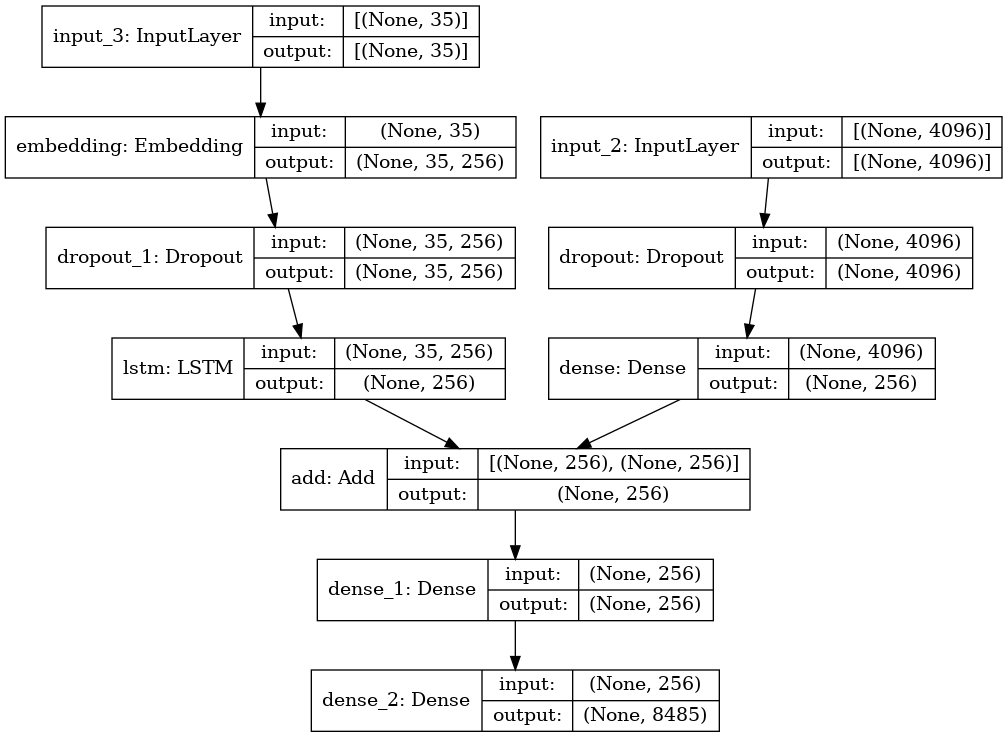

In [19]:
# encoder model
# image feature layer
input1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(input1)
fe2 = Dense(256, activation='relu')(fe1)

#sequence feature layer
input2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(input2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[input1, input2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

In [ ]:
# train the model
epochs = 20
batch_size = 32
steps = len(train)//batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, 
                               mapping, 
                               features, 
                               tokenizer, 
                               max_length, 
                               vocab_size, 
                               batch_size)
    # fit for one epoch
    model.fit(generator, epochs=5, steps_per_epoch=steps, verbose=1)

Epoch 1/5
227/227 [==============================] - 75s 309ms/step - loss: 5.2099
Epoch 2/5
227/227 [==============================] - 68s 299ms/step - loss: 3.9810
Epoch 3/5
227/227 [==============================] - 71s 311ms/step - loss: 3.5741
Epoch 4/5
227/227 [==============================] - 72s 318ms/step - loss: 3.3173
Epoch 5/5
227/227 [==============================] - 73s 320ms/step - loss: 3.1238
Epoch 1/5
227/227 [==============================] - 73s 319ms/step - loss: 2.9773
Epoch 2/5
227/227 [==============================] - 71s 310ms/step - loss: 2.8585
Epoch 3/5
227/227 [==============================] - 73s 321ms/step - loss: 2.7625
Epoch 4/5
227/227 [==============================] - 72s 317ms/step - loss: 2.6884
Epoch 5/5
227/227 [==============================] - 69s 306ms/step - loss: 2.6181
Epoch 1/5
227/227 [==============================] - 70s 307ms/step - loss: 2.5535
Epoch 2/5
227/227 [==============================] - 69s 305ms/step - loss: 2.4931
Epoc

In [31]:
# save the model
model.save(WORKING_DIR + '/model.h5')

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


## Generate Captions for Image

In [21]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [22]:
# generate caption for image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        y_pred = model.predict([image, sequence], verbose=0)
        # get index with high probability
        y_pred = np.argmax(y_pred)
        # convert index to word
        word = idx_to_word(y_pred, tokenizer)
        # stop if word not found
        if word is None:
            break
        
        # append word as input for generating next word
        in_text += " " + word
        
        #stop if we reach end tag
        if word == 'endseq':
            break
    
    return in_text

In [23]:
from nltk.translate.bleu_score import corpus_bleu

# Validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    y_pred = y_pred.split()
    # append to list
    actual_caption = [caption.split() for caption in captions]
    actual.append(actual_caption)
    

  0%|          | 0/810 [00:00<?, ?it/s]

AssertionError: The number of hypotheses and their reference(s) should be the same 

In [29]:
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

AssertionError: The number of hypotheses and their reference(s) should be the same 

## Visualize the Results

In [30]:
from PIL import Image
import matplotlib.pyplot as plt

def generate_caption(image_name):
    # load the image
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, 'Images', image_name)
    image = Image.open(img_path)
    caption = mapping[image_id]
    print('------------------Actual------------------')

    for caption in captions:
        print(caption)

    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('----------------Predicted-----------------')
    print(y_pred)
    plt.imshow(image)

------------------Actual------------------
startseq man in pink shirt climbs rock face endseq
startseq man is rock climbing high in the air endseq
startseq person in red shirt climbing up rock face covered in assist handles endseq
startseq rock climber in red shirt endseq
startseq rock climber practices on rock climbing wall endseq
----------------Predicted-----------------
startseq man lays on bench with his dog endseq


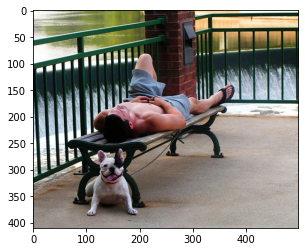

In [33]:
generate_caption("1003163366_44323f5815.jpg")

------------------Actual------------------
startseq man in pink shirt climbs rock face endseq
startseq man is rock climbing high in the air endseq
startseq person in red shirt climbing up rock face covered in assist handles endseq
startseq rock climber in red shirt endseq
startseq rock climber practices on rock climbing wall endseq
----------------Predicted-----------------
startseq dog runs through the snow endseq


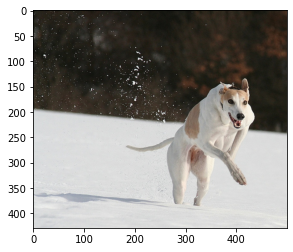

In [36]:
generate_caption("101654506_8eb26cfb60.jpg")

------------------Actual------------------
startseq man in pink shirt climbs rock face endseq
startseq man is rock climbing high in the air endseq
startseq person in red shirt climbing up rock face covered in assist handles endseq
startseq rock climber in red shirt endseq
startseq rock climber practices on rock climbing wall endseq
----------------Predicted-----------------
startseq two people are standing on the edge of waterway fountain endseq


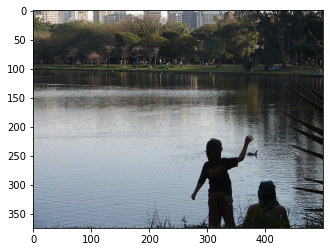

In [37]:
generate_caption("1022454332_6af2c1449a.jpg")

------------------Actual------------------
startseq man in pink shirt climbs rock face endseq
startseq man is rock climbing high in the air endseq
startseq person in red shirt climbing up rock face covered in assist handles endseq
startseq rock climber in red shirt endseq
startseq rock climber practices on rock climbing wall endseq
----------------Predicted-----------------
startseq man rides his bike through the air endseq


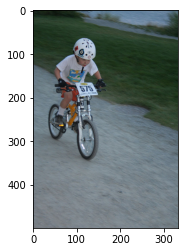

In [45]:
generate_caption("1075716537_62105738b4.jpg")